In [1]:
# general purpose python
import collections
import datetime
import glob
import importlib
import itertools
import json
import math
import os
import pickle
import random
import re
import shutil
import sys
import time
import warnings

# general purpose data science
import IPython
import ipywidgets as ipw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm

# computer vision
import cv2
import imageio
import PIL
from PIL import *

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# geospatial
import rasterio as rio
import rasterio.features

warnings.filterwarnings('ignore')

np.random.seed(1337)

mpl.rcParams['figure.dpi'] = 400

IPython.core.display.display(IPython.core.display.HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_colwidth = 32
pd.options.display.float_format = '{:,.6f}'.format
pd.options.display.expand_frame_repr = False

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

plotly.offline.init_notebook_mode(connected=True)
plotly.io.templates.default = 'plotly_white'

In [2]:
data_dir = '../../data/movielens/'

## Load the data

In [3]:
movies = pd.read_csv(f'{data_dir}/movies_clean.csv')
ratings = pd.read_csv(f'{data_dir}/ratings_train.csv')

In [4]:
# filter out users and movies with too few ratings
min_user_ratings = 50
min_movie_ratings = 300

user_rating_counts = ratings.groupby('user_id').movie_id.count()
print(user_rating_counts.quantile([0.2 * i for i in range(6)]))
user_ids = user_rating_counts[user_rating_counts > min_user_ratings].index.tolist()

movie_rating_counts = ratings.groupby('movie_id').user_id.count()
print(movie_rating_counts.quantile([0.2 * i for i in range(6)]))
movie_ids = movie_rating_counts[movie_rating_counts > min_movie_ratings].index.tolist()

ratings = ratings[(ratings.user_id.isin(user_ids)) & (ratings.movie_id.isin(movie_ids))]
movies = movies[movies.movie_id.isin(movie_ids)]

0.000000       9.000000
0.200000      24.000000
0.400000      41.000000
0.600000      74.000000
0.800000     154.000000
1.000000   7,418.000000
Name: movie_id, dtype: float64
0.000000        1.000000
0.200000        2.000000
0.400000        7.000000
0.600000       42.000000
0.800000      297.000000
1.000000   53,894.000000
Name: user_id, dtype: float64


# Calculate similarities on top movies

## Select movies to calculate similarity on

In [5]:
n_movies = 40

In [6]:
movie_rating_counts = pd.DataFrame(ratings.groupby(['movie_id']).user_id.count())
movie_rating_counts.columns = ['rating_count']
movies = movies.merge(movie_rating_counts, left_on='movie_id', right_index=True)
top_movie_ids = movies.sort_values('rating_count', ascending=False).head(n_movies).movie_id.tolist()
movies.sort_values('rating_count', ascending=False).head(n_movies)[['movie_id', 'title', 'rating_count']]

,movie_id,title,rating_count
352,356,Forrest Gump (1994),38413
293,296,Pulp Fiction (1994),38038
587,593,"Silence of the Lambs, The (1...",36321
476,480,Jurassic Park (1993),35192
315,318,"Shawshank Redemption, The (1...",34919
257,260,Star Wars: Episode IV - A Ne...,33340
2486,2571,"Matrix, The (1999)",33324
583,589,Terminator 2: Judgment Day (...,32050
108,110,Braveheart (1995),31815
1171,1196,Star Wars: Episode V - The E...,30922


## Select users who have enough ratings

In [7]:
user_rating_counts = ratings[ratings.movie_id.isin(top_movie_ids)].groupby('user_id').movie_id.count()
user_ids = user_rating_counts[user_rating_counts >= (n_movies/2)].index.tolist()
print('number of users who have enough ratings: ', len(user_ids))

number of users who have enough ratings:  22363


## Prepare the data for similarity computation

In [8]:
# get dense rating matrix
r = ratings[(ratings.user_id.isin(user_ids)) & (ratings.movie_id.isin(top_movie_ids))][['user_id', 'movie_id', 'rating']]
r = r.pivot(index='user_id', columns='movie_id').sort_index()
print(r.shape)
r.head(10)

(22363, 40)


rating                                                                                   ...                                                                                          
movie_id     1        32       47       50       110      150      260      296      318      356   ...     1265     1270     1580     2028     2571     2762     2858     2959     3578     4993
user_id                                                                                             ...                                                                                          
11       4.500000 5.000000      nan      nan 4.000000 5.000000 5.000000 3.500000 5.000000 5.000000  ...      nan 5.000000      nan 5.000000      nan      nan      nan 4.500000 4.500000 5.000000
22       3.000000      nan 4.000000 4.000000 4.000000      nan      nan 5.000000 5.000000      nan  ...      nan      nan 3.000000 3.000000 3.000000      nan 3.000000 4.000000      nan      nan
24       4.000000      nan 4.000000 5.000000 4.000000 3.000000 5.000000 5.000000 5.000000 5.000000  ... 3.000000 4.000000 5.000000 5.000000 5.000000 5.000000 5.000000 5.000000 5.000000      nan
25            nan 3.500000 3.000000 3.500000 3.500000      nan      nan 4.000000 4.000000 4.000000  ... 3.500000      nan 1.500000 3.500000 3.500000      nan      nan 4.000000 3.500000 3.500000
54       4.000000 5.000000 4.000000 4.000000 5.000000      nan 4.000000      nan 5.000000 5.000000  ... 3.000000      nan      nan 5.000000 5.000000      nan 5.000000      nan 4.000000      nan
58       5.000000      nan 5.000000 5.000000 5.000000      nan      nan 5.000000 5.000000 4.500000  ...      nan      nan 4.000000 5.000000 5.000000 5.000000 4.500000 5.000000      nan 5.000000
69            nan 5.000000      nan 4.000000      nan      nan 5.000000      nan      nan 4.000000  ...      nan 3.000000      nan      nan      nan      nan      nan      nan      nan      nan
90       3.500000      nan 4.500000      nan      nan 3.500000 3.500000 3.500000 4.000000 5.000000  ...      nan      nan      nan 2.500000 2.000000 4.000000 5.000000 2.000000 3.500000      nan
91       4.000000 4.000000      nan 3.500000 5.000000      nan 4.500000 3.500000 4.000000 4.000000  ... 4.500000 4.000000      nan 4.000000 3.500000 4.000000 4.500000 5.000000 3.500000 5.000000
96       3.500000 4.000000 4.000000 3.000000      nan      nan 4.000000 4.500000 4.500000 3.500000  ...      nan 4.500000      nan 4.000000 4.500000 4.500000      nan      nan 3.500000 4.000000

[10 rows x 40 columns]

In [9]:
# normalize ratings by user ratings average
user_mean_ratings = ratings[ratings.user_id.isin(user_ids)][['user_id', 'rating']].groupby('user_id').rating.mean().sort_index()
print(user_mean_ratings.head(10))
for movie_id in r.columns:
    r[movie_id] -= user_mean_ratings.values
r.fillna(0, inplace=True)
print(r.shape)
r.head(10)

user_id
11   4.044669
22   3.620370
24   3.375635
25   3.635417
54   3.426573
58   4.160075
69   3.148472
90   3.515000
91   3.398649
96   3.487216
Name: rating, dtype: float64
(22363, 40)


rating                                                                                          ...                                                                                                   
movie_id      1         32        47        50        110       150       260       296      318      356   ...      1265      1270      1580      2028      2571     2762      2858      2959      3578      4993
user_id                                                                                                     ...                                                                                                   
11        0.455331  0.955331  0.000000  0.000000 -0.044669  0.955331  0.955331 -0.544669 0.955331 0.955331  ...  0.000000  0.955331  0.000000  0.955331  0.000000 0.000000  0.000000  0.455331  0.455331  0.955331
22       -0.620370  0.000000  0.379630  0.379630  0.379630  0.000000  0.000000  1.379630 1.379630 0.000000  ...  0.000000  0.000000 -0.620370 -0.620370 -0.620370 0.000000 -0.620370  0.379630  0.000000  0.000000
24        0.624365  0.000000  0.624365  1.624365  0.624365 -0.375635  1.624365  1.624365 1.624365 1.624365  ... -0.375635  0.624365  1.624365  1.624365  1.624365 1.624365  1.624365  1.624365  1.624365  0.000000
25        0.000000 -0.135417 -0.635417 -0.135417 -0.135417  0.000000  0.000000  0.364583 0.364583 0.364583  ... -0.135417  0.000000 -2.135417 -0.135417 -0.135417 0.000000  0.000000  0.364583 -0.135417 -0.135417
54        0.573427  1.573427  0.573427  0.573427  1.573427  0.000000  0.573427  0.000000 1.573427 1.573427  ... -0.426573  0.000000  0.000000  1.573427  1.573427 0.000000  1.573427  0.000000  0.573427  0.000000
58        0.839925  0.000000  0.839925  0.839925  0.839925  0.000000  0.000000  0.839925 0.839925 0.339925  ...  0.000000  0.000000 -0.160075  0.839925  0.839925 0.839925  0.339925  0.839925  0.000000  0.839925
69        0.000000  1.851528  0.000000  0.851528  0.000000  0.000000  1.851528  0.000000 0.000000 0.851528  ...  0.000000 -0.148472  0.000000  0.000000  0.000000 0.000000  0.000000  0.000000  0.000000  0.000000
90       -0.015000  0.000000  0.985000  0.000000  0.000000 -0.015000 -0.015000 -0.015000 0.485000 1.485000  ...  0.000000  0.000000  0.000000 -1.015000 -1.515000 0.485000  1.485000 -1.515000 -0.015000  0.000000
91        0.601351  0.601351  0.000000  0.101351  1.601351  0.000000  1.101351  0.101351 0.601351 0.601351  ...  1.101351  0.601351  0.000000  0.601351  0.101351 0.601351  1.101351  1.601351  0.101351  1.601351
96        0.012784  0.512784  0.512784 -0.487216  0.000000  0.000000  0.512784  1.012784 1.012784 0.012784  ...  0.000000  1.012784  0.000000  0.512784  1.012784 1.012784  0.000000  0.000000  0.012784  0.512784

[10 rows x 40 columns]

## Calculate similarities

[11  7  6  6  3  1  4  6  6  3 10 14 16  2 17  6 10  4 13 19  6  6 15  6
 12  6  4  4  4  4  9  4 18  3  6  8  6  6  3  5]


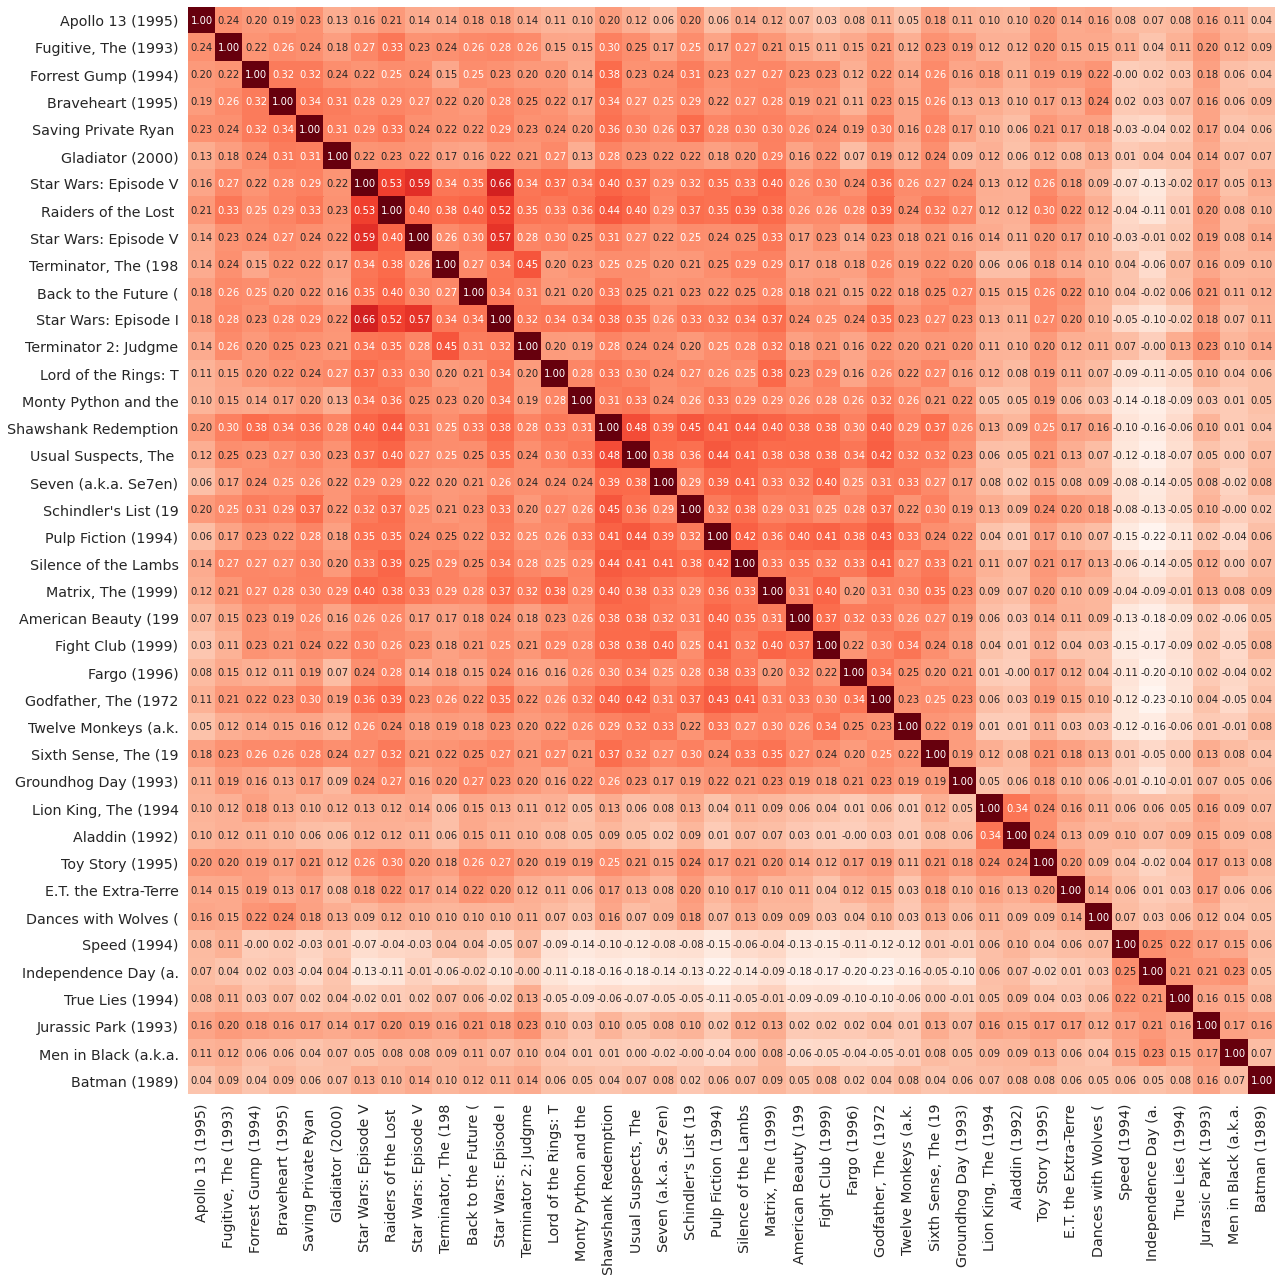

In [10]:
# calculate similarities
s = sklearn.metrics.pairwise.cosine_similarity(r.T)
titles = [title[:20] for title in movies[movies.movie_id.isin(top_movie_ids)].title.tolist()]

# hierarchical clustering to move similar items next to each other for better visualization
t = np.round((1 - s) / np.max(1 - s), decimals=3)
labels = scipy.cluster.hierarchy.fcluster(
            scipy.cluster.hierarchy.linkage(
                scipy.spatial.distance.squareform(t),
                method='average'),
            0.58,
            criterion='distance')
print(labels)
for i in range(n_movies):
    for j in range(i+1, n_movies):
        if labels[i] > labels[j]:
            labels[i], labels[j] = labels[j], labels[i]
            titles[i], titles[j] = titles[j], titles[i]
            
            tmp = np.copy(s[i,:])
            s[i,:] = s[j,:]
            s[j,:] = tmp
            
            tmp = np.copy(s[:,i])
            s[:,i] = s[:,j]
            s[:,j] = tmp

# plot similarity matrix
plt.figure(figsize=(20, 20))
sns.heatmap(
    data=s,
    vmin=np.min(s),
    vmax=np.max(s),
    cbar=False,
    square=True,
    annot=True,
    fmt='.2f',
    xticklabels=titles,
    yticklabels=titles,
    cmap='Reds')
plt.show()

# Find similar items to a movie

In [11]:
def similar_movies(source_movie_id, min_ratings=10, n_results=6):
    print('finding similar movies to: ', movies[movies.movie_id == source_movie_id].title.tolist()[0])
    
    # find users that rated the movie
    user_ids = ratings[ratings.movie_id == source_movie_id].user_id.unique()
    print('number of users that rated the movie: ', len(user_ids))
    
    # find movies that have enough ratings among these users
    ratings_by_users = ratings[ratings.user_id.isin(user_ids)]
    movie_rating_counts = ratings_by_users.groupby('movie_id').user_id.count()
    candidate_movie_ids = movie_rating_counts[movie_rating_counts >= min_ratings].index.tolist()
    print('number of candidate movies that have enough ratings: ', len(candidate_movie_ids))
    
    # get dense rating matrix
    r = ratings[(ratings.user_id.isin(user_ids)) & (ratings.movie_id.isin(candidate_movie_ids))][['user_id', 'movie_id', 'rating']]
    r = r.pivot(index='user_id', columns='movie_id').sort_index()

    # normalize ratings by user ratings average
    user_mean_ratings = ratings[ratings.user_id.isin(user_ids)][['user_id', 'rating']].groupby('user_id').rating.mean().sort_index()
    for movie_id in r.columns:
        r[movie_id] -= user_mean_ratings.values
    r.fillna(0, inplace=True)
    
    # compute similarities
    candidates = []
    def cos_sim(a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(a))
    for movie_id in candidate_movie_ids:
        candidates.append({
            'movie_id': movie_id,
            'title': movies[movies.movie_id == movie_id].values[0][1],
            'similarity': cos_sim(r[('rating', source_movie_id)], r[('rating', movie_id)])})
    candidates = pd.DataFrame(candidates)
    
    #return results
    if len(candidates):
        return candidates.sort_values(by='similarity', ascending=False).head(n_results)[['movie_id', 'title', 'similarity']]
    else:
        return None

In [12]:
seed_movie_ids = [3676, 52281, 4011, 1214, 6]
for movie_id in seed_movie_ids:
    print(similar_movies(movie_id, min_ratings=50, n_results=6), '\n', '-' * 60)

finding similar movies to:  Eraserhead (1977)
number of users that rated the movie:  1958
number of candidate movies that have enough ratings:  4186
      movie_id                         title  similarity
2051      3676             Eraserhead (1977)    1.000000
1142      2076            Blue Velvet (1986)    0.223258
2560      4848       Mulholland Drive (2001)    0.193105
655       1206    Clockwork Orange, A (1971)    0.192681
496        924  2001: A Space Odyssey (1968)    0.173311
837       1464           Lost Highway (1997)    0.156714 
 ------------------------------------------------------------
finding similar movies to:  Grindhouse (2007)
number of users that rated the movie:  2766
number of candidate movies that have enough ratings:  4026
      movie_id                     title  similarity
3346     52281         Grindhouse (2007)    1.000000
154        296       Pulp Fiction (1994)    0.293877
2568      6874  Kill Bill: Vol. 1 (2003)    0.277426
3375     53519        Death 